<a href="https://colab.research.google.com/github/MorganChidley/Final-Year-Project/blob/main/ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA/Feature Engineering

In [ ]:
import pandas as pd

# Load the dataset
file_path = "MyDataSET.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the data
data.head()

In [ ]:
import pandas as pd

# Load the dataset
file_path = "MyDataSET.csv"
data= pd.read_csv(file_path)

# Get the shape of the data (number of rows and columns)
data.shape

In [ ]:
import pandas as pd

# Load the dataset
file_path = "MyDataSET.csv"
data= pd.read_csv(file_path)

# Check for missing values
data.isnull().sum()

In [ ]:
import pandas as pd

# Load the dataset
file_path = "MyDataSET.csv"
data= pd.read_csv(file_path)

# Remove duplicate rows
data.drop_duplicates(inplace=True)

# Check the new shape of the dataset
data.shape



In [ ]:
import pandas as pd
import re
from urllib.parse import urlparse

# Feature extraction functions

def url_length(url):
    """Returns the length of the URL."""
    return len(url)

def has_ip_address(url):
    """Checks if the URL contains an IP address."""
    ip_pattern = r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}"
    return 1 if re.search(ip_pattern, url) else 0

def count_special_chars(url):
    """Counts occurrences of special characters."""
    special_chars = ["-", "_", "%", "/", ".", "#"]
    return {char: url.count(char) for char in special_chars}

def count_subdomains(url):
    """Counts the number of subdomains."""
    parsed_url = urlparse(url).netloc
    return parsed_url.count('.')

def has_https(url):
    """Checks if the URL uses HTTPS."""
    return 1 if urlparse(url).scheme == "https" else 0


def count_query_parameters(url):
    """Counts the number of query parameters in the URL."""
    query = urlparse(url).query
    return len(query.split("&")) if query else 0

# Apply feature extraction

data["url_length"] = data["URL"].apply(url_length)
data["subdomain_count"] = data["URL"].apply(count_subdomains)
data["https"] = data["URL"].apply(has_https)
data["has_ip_address"] = data["URL"].apply(has_ip_address)
data["query_parameters_count"] = data["URL"].apply(count_query_parameters)

# Extract special character counts only once
if not all(char in data.columns for char in ["-", "_", "%", "/", ".", "#"]):
    special_chars_df = data["URL"].apply(count_special_chars).apply(pd.Series)
    data = pd.concat([data, special_chars_df], axis=1)

# Remove duplicate columns
data = data.loc[:, ~data.columns.duplicated()]

# Converts all feature changes to a new csv file
data.to_csv("modified_dataset.csv", index=False)

# Display first few rows with new features
data.head()

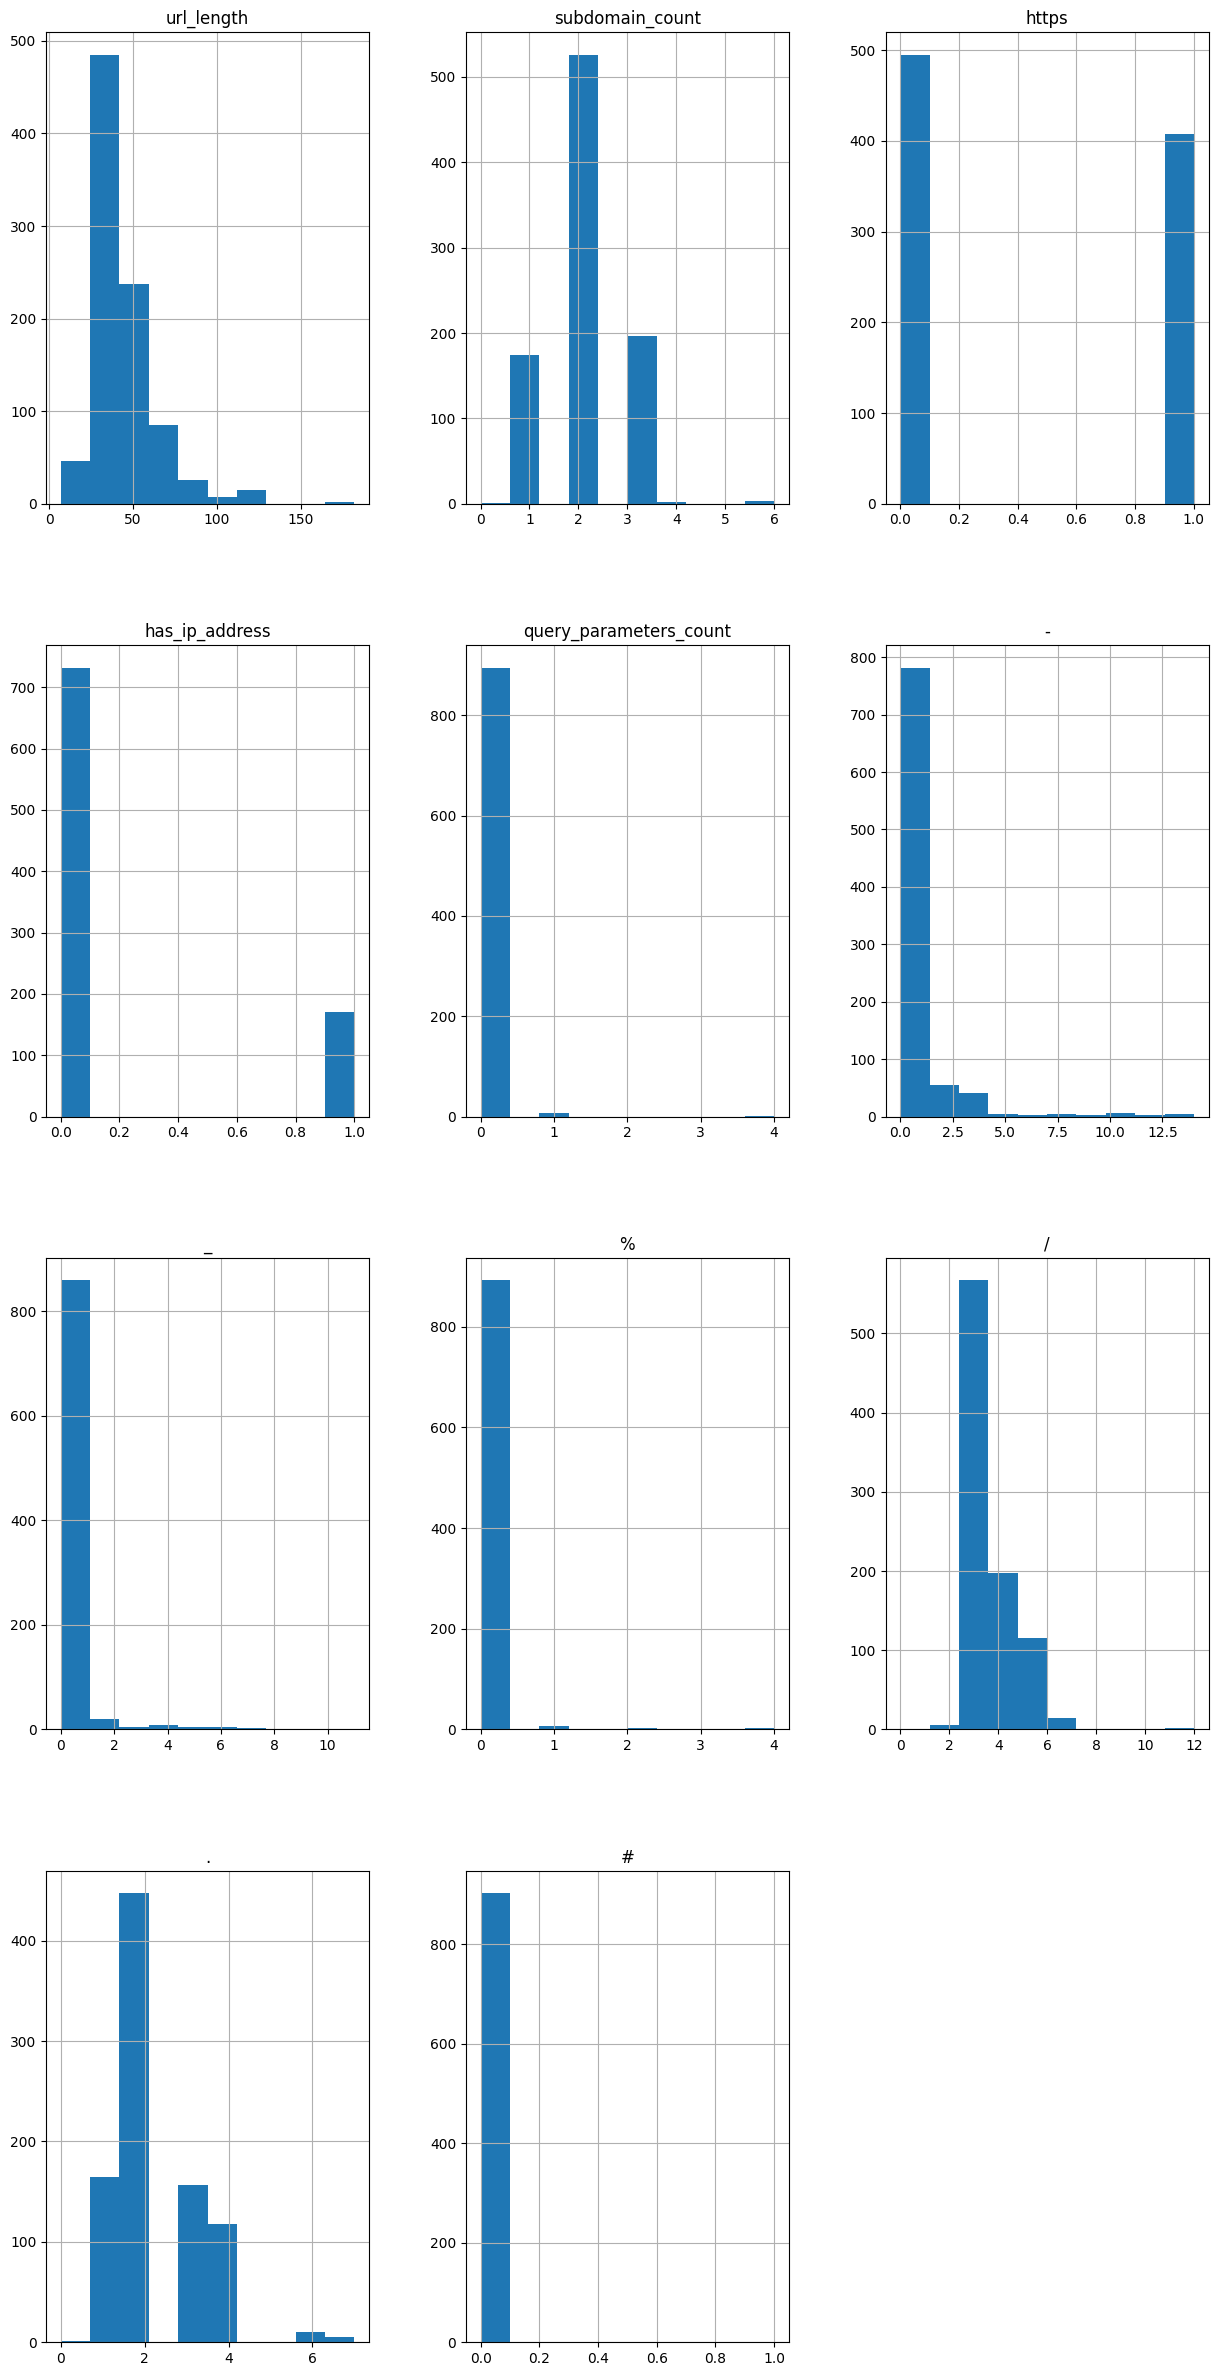

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load Dataset
data = pd.read_csv("modified_dataset.csv")

# Drop the 'ClassLabel' column
data = data.drop('ClassLabel', axis=1)

data.hist(figsize=(15, 30))  # Adjust figsize as needed
plt.show()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load Dataset
data = pd.read_csv("modified_dataset.csv")

# Drop the 'ClassLabel' column
data = data.drop('ClassLabel', axis=1)

# Select numeric columns
numeric_data = data.select_dtypes(include=np.number)

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()

# Display correlation matrix as a styled table
correlation_table = correlation_matrix.style.background_gradient(cmap='coolwarm')

correlation_table

,url_length,subdomain_count,https,has_ip_address,query_parameters_count,-,_,%,/,.,#
url_length,1.000000,-0.229091,0.330789,-0.274492,0.269367,0.616937,0.288173,0.131856,0.501919,-0.071849,0.119711
subdomain_count,-0.229091,1.000000,-0.434672,0.672114,-0.014639,-0.266455,-0.014512,-0.025230,-0.350383,0.837786,0.046302
https,0.330789,-0.434672,1.000000,-0.438803,0.042369,0.147059,0.279746,0.095200,0.420651,-0.430477,0.036675
has_ip_address,-0.274492,0.672114,-0.438803,1.000000,-0.001475,-0.204047,-0.116877,-0.045748,-0.242214,0.699141,-0.016093
query_parameters_count,0.269367,-0.014639,0.042369,-0.001475,1.000000,0.039277,0.070849,-0.007246,0.076901,0.202497,0.206691
-,0.616937,-0.266455,0.147059,-0.204047,0.039277,1.000000,-0.093391,-0.037383,0.232924,-0.213436,0.043034
_,0.288173,-0.014512,0.279746,-0.116877,0.070849,-0.093391,1.000000,0.375488,0.112548,-0.033165,-0.009122
%,0.131856,-0.025230,0.095200,-0.045748,-0.007246,-0.037383,0.375488,1.000000,0.057619,-0.037756,-0.003152
/,0.501919,-0.350383,0.420651,-0.242214,0.076901,0.232924,0.112548,0.057619,1.000000,-0.253984,0.126814
.,-0.071849,0.837786,-0.430477,0.699141,0.202497,-0.213436,-0.033165,-0.037756,-0.253984,1.000000,0.053373


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from IPython.display import display # Import for display function

# Load dataset
data = pd.read_csv("modified_dataset.csv")

X = data.drop(['ClassLabel', "URL"], axis=1)
y = data['ClassLabel']

# Mutual Information
mutual_info = mutual_info_classif(X, y)
feature_scores = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mutual_info})
feature_scores = feature_scores.sort_values(by=['Mutual_Information'], ascending=False)


# Display mutual information scores in a table
display(feature_scores)



,Feature,Mutual_Information
8,/,0.336972
2,https,0.226994
0,url_length,0.187002
9,.,0.130429
1,subdomain_count,0.126543
6,_,0.120222
5,-,0.069777
4,query_parameters_count,0.046961
3,has_ip_address,0.037975
7,%,0.013376


# Baseline Model Development

In [ ]:
from pickle import TRUE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from IPython.display import display

# Load Dataset
data = pd.read_csv("modified_dataset.csv")

# Feature Selection
features = ['url_length', 'subdomain_count', 'https', "-", "_", "%", "/", ".", "#",
            "has_ip_address", "query_parameters_count"]
X = data[features]
y = data['ClassLabel']  # Target variable

# Handle missing values (fill with median)
X.fillna(X.median(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train and evaluate multiple models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models using cross-validation
kfold_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='accuracy')
    kfold_results[model_name] = {
        "Model": model_name,
        "Mean Accuracy": np.mean(scores),
        "Standard Deviation": np.std(scores)
    }

# Store results in a list of dictionaries
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
# Display the DataFrame

   # Extract precision, recall, and F1-score for each class
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    precision = report_dict['weighted avg']['precision']
    recall = report_dict['weighted avg']['recall']
    f1_score = report_dict['weighted avg']['f1-score']

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': conf_matrix,
    })

# Create a Pandas DataFrame from the results
results_df = pd.DataFrame(results)
kfold_results_df = pd.DataFrame(kfold_results.values())

# Reorder columns
kfold_results_df = kfold_results_df[['Model', 'Mean Accuracy', 'Standard Deviation']]

# Display the DataFrame
display(results_df)
display(kfold_results_df)

# Hyperparameter Tuning

**Hyperparamter Tuning using grid search**

In [ ]:
from pickle import TRUE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from IPython.display import display

# Load Dataset
data = pd.read_csv("modified_dataset.csv")

# Feature Selection
features = ['url_length', 'subdomain_count', 'https', "-", "_", "%", "/", ".", "#",
            "has_ip_address", "query_parameters_count"]
X = data[features]
y = data['ClassLabel']  # Target variable

# Handle missing values (fill with median)
X.fillna(X.median(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models and parameter grids for tuning
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

# Define models and parameter grids for tuning
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    },
    "Decision Tree": {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "MLP": {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01]
    }
}


# Perform hyperparameter tuning and evaluate models
cv_results = {}
for model_name, param_grid in param_grids.items():
    print(f"Tuning {model_name}...")
    model = models[model_name]  # Get model instance from dictionary
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_scaled, y)

    # Store results
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    cv_results[model_name] = {
        "Best Parameters": best_params,
        "Best Accuracy": best_score
    }

# Print and log results
log_data = []
for model, result in cv_results.items():
    print(f"{model}: Best Accuracy = {result['Best Accuracy']:.4f}, Best Parameters = {result['Best Parameters']}")
    log_data.append([model, result['Best Accuracy'], result['Best Parameters']])

# Save tuning results to CSV
df_log = pd.DataFrame(log_data, columns=['Model', 'Best Accuracy', 'Best Parameters'])
df_log.to_csv("Model_Tuning_Results.csv", index=False)

print("Hyperparameter tuning complete! Results saved in Model_Tuning_Results.csv")


**Model Optimisation, Validation Curves, Over/Under fitting**

In [ ]:
from pickle import TRUE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from IPython.display import display

# Load Dataset
data = pd.read_csv("modified_dataset.csv")

# Feature Selection
features = ['url_length', 'subdomain_count', 'https', "-", "_", "%", "/", ".", "#",
            "has_ip_address", "query_parameters_count"]
X = data[features]
y = data['ClassLabel']  # Target variable

# Handle missing values (fill with median)
X.fillna(X.median(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models and parameter grids for tuning
models = {
    "Logistic Regression": LogisticRegression(C=0.1, solver='lbfgs'),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=10),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10),
    "SVM": SVC(C=10, kernel='rbf'),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,50), activation='tanh', solver='adam', alpha=0.001, max_iter=500)
}

# Function to plot learning curves
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Accuracy')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='red', alpha=0.2)

    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve: {model_name}")
    plt.legend()
    plt.show()

# Plot learning curves for all models
for model_name, model in models.items():
    plot_learning_curve(model, X_scaled, y, model_name)

# Feature Importance (for Decision Tree & Random Forest)
def plot_feature_importance(model, model_name):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 5))
    plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx], color='teal')
    plt.xlabel("Feature Importance")
    plt.title(f"Feature Importance: {model_name}")
    plt.show()

# Train tree-based models and plot feature importance
tree_models = ["Decision Tree", "Random Forest"]
for model_name in tree_models:
    model = models[model_name].fit(X_scaled, y)
    plot_feature_importance(model, model_name)

print("Analysis complete! Check the plots for insights.")



**Validation for performance esitmates**

In [ ]:
from pickle import TRUE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from IPython.display import display
from sklearn.pipeline import Pipeline

# Load Dataset
data = pd.read_csv("modified_dataset.csv")

# Feature Selection
features = ['url_length', 'subdomain_count', 'https', "-", "_", "%", "/", ".", "#",
            "has_ip_address", "query_parameters_count"]
X = data[features]
y = data['ClassLabel']  # Target variable

# Handle missing values (fill with median)
X.fillna(X.median(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define models and parameter grids for tuning
models = {
    "Logistic Regression": LogisticRegression(C=0.1, solver='lbfgs'),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=10),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10),
    "SVM": SVC(C=10, kernel='rbf'),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,50), activation='tanh', solver='adam', alpha=0.001, max_iter=500)
}

# Define models with pipelines
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(C=0.1, solver='lbfgs'))
    ]),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=10),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10),
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(C=10, kernel='rbf'))
    ]),
    "MLP": Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='adam', alpha=0.001, max_iter=500))
    ])
}

# Nested Cross-Validation Setup
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Perform Nested CV Evaluation
cv_results = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name} using Nested Cross-Validation...")
    scores = cross_val_score(model, X_train, y_train, cv=outer_cv, scoring='accuracy', n_jobs=-1)
    mean_score, std_score = np.mean(scores), np.std(scores)

    # Store results
    cv_results[model_name] = {
        "Mean Accuracy": mean_score,
        "Std Deviation": std_score
    }

# Print results
for model, result in cv_results.items():
    print(f"{model}: Mean Accuracy = {result['Mean Accuracy']:.4f}, Std Dev = {result['Std Deviation']:.4f}")

# Evaluate final models on the validation set
val_results = {}
for model_name, model in models.items():
       model.fit(X_train, y_train)
       val_accuracy = model.score(X_val, y_val)  # Use X_val and y_val here
       val_results[model_name] = val_accuracy


# Print validation results
print("\nFinal Validation Set Performance:")
for model, acc in val_results.items():
    print(f"{model}: Validation Accuracy = {acc:.4f}")

print("Nested Cross-Validation and Validation Set Evaluation Complete!")


